In [1]:
import os
import math
import json
import datetime
import numpy as np

from tifffile import tifffile

from skimage import morphology, filters, transform, measure
from skimage.feature import peak_local_max

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mp
from matplotlib import cm

from scipy import stats, optimize
from scipy.interpolate import interp1d

def plane(X, a, b, c):
    return(a*X[0] + b * X[1] + c)

def twoDQuadFunc(X, a, b, c, d, e, f):
    return(a*X[0]**2 + b*X[0]*X[1] + c*X[1]**2 + d*X[0] + e*X[1] + f)



def delayed_exponential_on(t, b, tau, upper_lim, lower_lim):
    de = upper_lim - (upper_lim - lower_lim) * np.exp(b*(t - tau))
    de[t < tau] = lower_lim
    return(de)

def delayed_exponential_on_off(t, b_on, b_off, tau_on, tau_off, upper_lim, lower_lim, lower_lim2):
    de = upper_lim - (upper_lim - lower_lim) * np.exp(b_on*(t - tau_on))
    de[t < tau_on] = lower_lim
    
    val = upper_lim - (upper_lim - lower_lim) * np.exp(b_on*(tau_off - tau_on))
    de[t > tau_off] =  lower_lim2 + (val - lower_lim2) * np.exp(b_off*(t[t > tau_off] - tau_off))
    return(de)
        
        
class mm_microscope_image:
    def __init__(self, path):
        self.filepath = path
        self.array = None
        self.framenumber = np.nan
        self.elapsed_time_s = np.nan
        self.channel = np.nan
        self.pixelsizeum = None
        self.md = None
        self.H = None
        self.W = None

        with tifffile.TiffFile(path) as tif:
            try:
                md = json.loads(tif.imagej_metadata["Info"])
                self.md = md
                self.array = tif.asarray()
                self.framenumber = None
                self.elapsed_time_s = md['ElapsedTime-ms']/1000.
                self.channel = None
                try:
                    self.pixelsizeum = md['PixelSize_um']
                except:
                    self.pixelsizeum = md['PixelSizeUm']
                self.H = md['Width']
                self.W = md['Height']
                self.stage_x = md['XPositionUm']
                self.stage_y = md['YPositionUm']
            except:
                self.md = tif.shaped_metadata[0]
                self.array = tif.asarray()
                self.framenumber = None
                self.channel = None
                self.H, self.W = self.md['shape']
                try:
                    self.elapsed_time_s = float(self.md['elapsed_time_s'])
                    self.pixelsizeum = self.md['PixelSizeUm']
                except:
                    pass
                try:
                    self.stage_x = self.md['stage_x_pos']
                    self.stage_y = self.md['stage_y_pos']
                except:
                    pass
    
class led_metadata:
    def __init__(self, path):
        self.filepath = path
        
        
        with open(self.filepath) as f:
            lines = f.readlines()
            summary = lines[0]
            data = lines[1:]

            timestamps = []
            intensities = []

            for i in data:
                timestamp, setstring = i.strip().split('\t')

                intensity = setstring.split(' ')[-1]

                timestamps.append(datetime.datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S.%f'))
                intensities.append(int(intensity))
            
            self.timepoints = np.array(timestamps)
            self.ledvalues = np.array(intensities)
            


class mm_acquisition:
    
    def __init__(self, acq_path):
        
        self.acq_path = acq_path
        self.microscope_image_list = []
        
        try:
            with open(acq_path + '/metadata.txt', "r") as read_file:
                self.acq_mdata = json.load(read_file)
        except:
            pass
        
        try:
            self.start_time = datetime.datetime.strptime(self.acq_mdata['Summary']['StartTime'][:-6], '%Y-%m-%d %H:%M:%S.%f')
        except:
            pass
        try:
            self.start_time = datetime.datetime.strptime(self.acq_mdata['Summary']['StartTime'][:-6], '%Y-%m-%d %H:%M:%S')
        except:
            pass
        
        try:
            self.led_data = led_metadata(acq_path + '/intensities.txt')
            self.led_timepoints_sec = [(t - self.start_time).total_seconds() for t in self.led_data.timepoints]
        except:
            print("Problem with LED metadata")
            
        for i in np.sort(os.listdir(self.acq_path)):
            
            if ('img' in i) & ('tif' in i):
                try:
                    i = i.decode()
                except:
                    pass

                if '.tif' in i:
                    img_obj = mm_microscope_image(self.acq_path + '/' + i)

                    try:
                        name_fragments = i.split('_')
                        img_obj.framenumber = int(name_fragments[3][4:])
                        img_obj.channel = int(name_fragments[1][7:])

                    except:
                        pass

                    try:
                        img_obj.framenumber = int(self.acq_mdata['Coords-Default/' + i]['Frame'])
                        img_obj.channel = int(self.acq_mdata['Coords-Default/' + i]['ChannelIndex'])
                    except:
                        pass

                    try:
                        img_obj.framenumber = int(self.acq_mdata['Coords-' + i]['time'])
                        img_obj.channel = int(self.acq_mdata['Coords-' + i]['channel'])
                    except:
                        pass


                    self.microscope_image_list.append(img_obj)

        self.channels = np.array([m.channel for m in self.microscope_image_list])
        self.framenumbers = np.array([m.framenumber for m in self.microscope_image_list])
        self.elapsedtimes = np.array([m.elapsed_time_s for m in self.microscope_image_list])
        
        imstack = np.array([m.array for m in self.microscope_image_list])
        
        self.ch0_stack = np.zeros((np.nanmax(self.framenumbers) + 1, self.microscope_image_list[0].H, self.microscope_image_list[0].W))
        self.ch1_stack = np.zeros((np.nanmax(self.framenumbers) + 1, self.microscope_image_list[0].H, self.microscope_image_list[0].W))
        self.ch2_stack = np.zeros((np.nanmax(self.framenumbers) + 1, self.microscope_image_list[0].H, self.microscope_image_list[0].W))
        
        for i in self.microscope_image_list:
            if i.channel == 0:
                self.ch0_stack[i.framenumber] = i.array
            if i.channel == 1:
                self.ch1_stack[i.framenumber] = i.array
            if i.channel == 2:
                self.ch2_stack[i.framenumber] = i.array

                
        self.estimate_background()
        self.estimate_stationary_single_cell_signals()
        
    def estimate_background(self):
        img = np.median(self.ch0_stack, axis = 0)
        smth1 = filters.gaussian(img, 3, preserve_range = True)
        smth2 = filters.gaussian(img, 30, preserve_range = True)
        DoG = smth1 - smth2
        foreground = DoG > 0
        foreground = morphology.binary_dilation(foreground, selem = morphology.disk(20))
        background = img.copy().astype(float)
        background[foreground] = np.nan
        
        h, w = background.shape
        xx, yy = np.meshgrid(np.arange(h), np.arange(w))
        zz_ch0 = background
        xx = xx[np.isfinite(background)]
        yy = yy[np.isfinite(background)]
        zz_ch0 = zz_ch0[np.isfinite(background)]
        X = np.array([xx, yy])
        popt_ch0, pcov = optimize.curve_fit(twoDQuadFunc, X, zz_ch0, p0 = [1, 1, 1, 1, 1, 500])
        X = np.meshgrid(np.arange(h), np.arange(w))
        self.ch0_estimated_bg = twoDQuadFunc(X, popt_ch0[0], popt_ch0[1], popt_ch0[2], popt_ch0[3], popt_ch0[4], popt_ch0[5])
        self.ch0_stack_bgcorrected = np.array([i.astype(float) - self.ch0_estimated_bg for i in self.ch0_stack])

        img = np.median(self.ch1_stack, axis = 0)
        smth1 = filters.gaussian(img, 3, preserve_range = True)
        smth2 = filters.gaussian(img, 30, preserve_range = True)
        DoG = smth1 - smth2
        foreground = DoG > 0
        foreground = morphology.binary_dilation(foreground, selem = morphology.disk(20))
        background = img.copy().astype(float)
        background[foreground] = np.nan
        xx, yy = np.meshgrid(np.arange(h), np.arange(w))
        zz_ch0 = background
        xx = xx[np.isfinite(background)]
        yy = yy[np.isfinite(background)]
        zz_ch0 = zz_ch0[np.isfinite(background)]
        X = np.array([xx, yy])
        popt_ch0, pcov = optimize.curve_fit(twoDQuadFunc, X, zz_ch0, p0 = [1, 1, 1, 1, 1, 500])
        X = np.meshgrid(np.arange(h), np.arange(w))
        self.ch1_estimated_bg = twoDQuadFunc(X, popt_ch0[0], popt_ch0[1], popt_ch0[2], popt_ch0[3], popt_ch0[4], popt_ch0[5])
        self.ch1_stack_bgcorrected = np.array([i.astype(float) - self.ch1_estimated_bg for i in self.ch1_stack])
        
    def estimate_stationary_single_cell_signals(self):
        smim = filters.gaussian(self.ch0_stack_bgcorrected[0], 15, preserve_range = True)
        y, x = peak_local_max(smim).T
        D = 10
        within_bounds_filter = (x > D) & (x < 1024 - D) & (y > D) & (y < 1024 - D)
        self.cell_centers_x = x[within_bounds_filter]
        self.cell_centers_y = y[within_bounds_filter]
        
        single_cell_ch0 = []
        single_cell_ch1 = []
        for i in range(len(self.cell_centers_x)):
            xc = int(round(self.cell_centers_x[i]))
            yc = int(round(self.cell_centers_y[i]))

            crop0 = self.ch0_stack_bgcorrected[:, yc - D : yc + D + 1 , xc - D : xc + D + 1]
            crop1 = self.ch1_stack_bgcorrected[:, yc - D : yc + D + 1, xc - D : xc + D + 1]
            
            single_cell_ch0.append(np.average(crop0, axis = (1,2)))
            single_cell_ch1.append(np.average(crop1, axis = (1,2)))
        
        self.single_cell_ch0 = np.array(single_cell_ch0)
        self.single_cell_ch1 = np.array(single_cell_ch1)
        
        baseline_ch0 = np.average(self.single_cell_ch0[:,:5], axis = 1)
        baseline_ch1 = np.average(self.single_cell_ch1[:,:5], axis = 1)
        self.single_cell_ch0_filtered = self.single_cell_ch0[baseline_ch0 >= 200]
        self.single_cell_ch1_filtered = self.single_cell_ch1[baseline_ch1 >= 200]
        
        

# Figure S1B

In [2]:
filepath = 'data/figs1data/201128_35-52-97-mCherryPAK_undiff_10uMLatB_twoSpotSwap_3/'

mma = mm_acquisition(filepath)
pixum = mma.microscope_image_list[0].pixelsizeum

if (pixum == 0) | (pixum is None):
    pixum = 0.217

ch0_baseline = []
ch1_baseline = []

ch0D = []
ch1D = []

D = 100
xc = 730
yc = 510

ch0 = mma.ch0_stack_bgcorrected[0][yc-D:yc+D,xc-D:xc+D]
smth_ch0 = filters.gaussian(ch0, 2, preserve_range=True)
bin_ch0 = smth_ch0 > 100
bin_ch0 = morphology.remove_small_objects(bin_ch0, 100)
lbl_ch0 = measure.label(bin_ch0)
reg_ch0 = measure.regionprops(lbl_ch0)
dist_to_middle = np.array([np.hypot(r.centroid[0] - D, r.centroid[1] - D) for r in reg_ch0])
lbl_of_interest = reg_ch0[np.argmin(dist_to_middle)].label
isolated_cell = lbl_ch0 == lbl_of_interest
yc, xc = measure.regionprops(measure.label(isolated_cell))[0].centroid
yc, xc = 510+int(yc)-D, 730+int(xc)-D

cmax0 = 1.1*np.percentile(mma.ch0_stack_bgcorrected[15][yc-D:yc+D,xc-D:xc+D], 99.999)
cmax1 = 1.1*np.percentile(mma.ch1_stack_bgcorrected[15][yc-D:yc+D,xc-D:xc+D], 99.999)

for T in range(len(mma.ch0_stack)):
    
    
    ch0 = mma.ch0_stack_bgcorrected[T][yc-D:yc+D,xc-D:xc+D]
    ch1 = mma.ch1_stack_bgcorrected[T][yc-D:yc+D,xc-D:xc+D]
    ch2 = mma.ch2_stack[T][yc-D:yc+D,xc-D:xc+D]

    if T == 0:
        smth_ch0 = filters.gaussian(ch0, 2, preserve_range=True)
        bin_ch0 = smth_ch0 > 100
        bin_ch0 = morphology.remove_small_objects(bin_ch0, 100)
        lbl_ch0 = measure.label(bin_ch0)
        reg_ch0 = measure.regionprops(lbl_ch0)
        dist_to_middle = np.array([np.hypot(r.centroid[0] - D, r.centroid[1] - D) for r in reg_ch0])
        lbl_of_interest = reg_ch0[np.argmin(dist_to_middle)].label
        isolated_cell = lbl_ch0 == lbl_of_interest

    smth_ch2 = filters.gaussian(ch2, 2, preserve_range=True)
    bin_ch2 = smth_ch2 > 600

    yy, xx = np.where(isolated_cell)




/tmp/ipykernel_4182/795337419.py:15: UserWarning: No contour levels were found within the data range.
  plt.contour(isolated_cell, levels = [False], colors = 'firebrick', linewidths = 0.6, linestyles = '--')
/tmp/ipykernel_4182/795337419.py:16: UserWarning: No contour levels were found within the data range.
  plt.contour(bin_ch2, levels = [False], colors = 'C0', linewidths = 0.6, linestyles = '--')


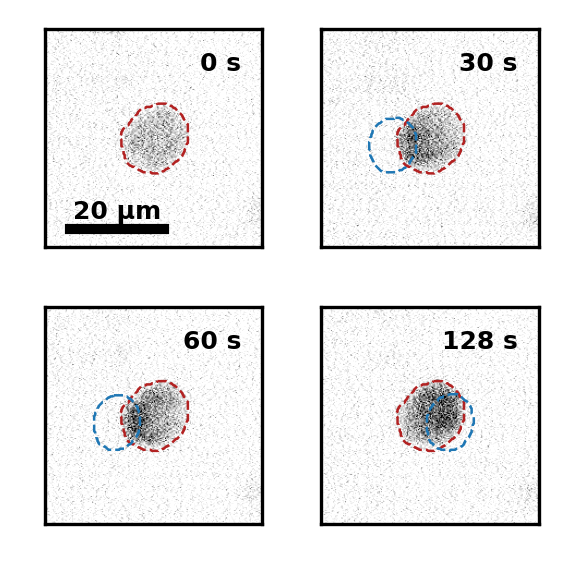

In [3]:
t1 = mma.elapsedtimes[mma.channels == 1]
t1 -= t1[25]

plt.figure(figsize = (2,2), dpi = 300)

for n, T in enumerate([25, 38, 51, 80]):
    ax = plt.subplot(2, 2, n + 1)
    ch0 = mma.ch0_stack_bgcorrected[T][yc-D:yc+D,xc-D:xc+D]
    ch1 = mma.ch1_stack_bgcorrected[T][yc-D:yc+D,xc-D:xc+D]
    ch2 = mma.ch2_stack[T][yc-D:yc+D,xc-D:xc+D]
    smth_ch2 = filters.gaussian(ch2, 2, preserve_range=True)
    bin_ch2 = smth_ch2 > 600
    
    plt.imshow(ch1, cmap = 'Greys', vmin = 0, vmax = 200)
    plt.contour(isolated_cell, levels = [False], colors = 'firebrick', linewidths = 0.6, linestyles = '--')
    plt.contour(bin_ch2, levels = [False], colors = 'C0', linewidths = 0.6, linestyles = '--')
    rect = mp.Rectangle((0.2*D, 1.8*D), 20/pixum, 6, color = 'k')
    if n == 0:
        ax.add_patch(rect)
        ax.text(0.2 * D + 10/pixum, 1.78*D, '20 μm', ha = 'center', va = 'bottom', fontweight = 'bold', fontsize = 6)

    timestamp = int(np.round(t1[T], 0))
    ax.text(1.8*D, 0.2*D, str(timestamp) + ' s', ha = 'right', va = 'top', fontsize = 6, fontweight = 'bold')

    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()
plt.show()


# Figure S1D

/tmp/ipykernel_4182/1390665313.py:29: UserWarning: No contour levels were found within the data range.
  plt.contour(x1, t1, np.array(smth_ch2_kymo) > 600, levels = [False], colors = 'C0', linewidths = 1)


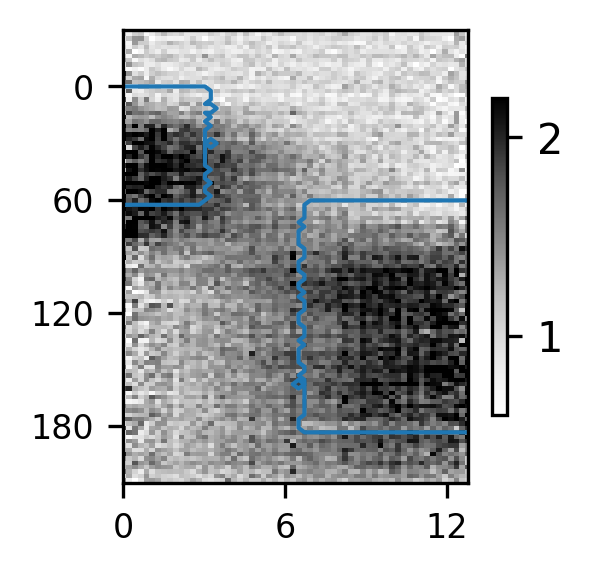

In [4]:
ch0_kymo = []
ch1_kymo = []
ch2_kymo = []

ch0_baseline = np.average(mma.ch0_stack_bgcorrected[:25,yc-D:yc+D,xc-D:xc+D], axis = 0)[yy, xx]
ch1_baseline = np.average(mma.ch1_stack_bgcorrected[:25,yc-D:yc+D,xc-D:xc+D], axis = 0)[yy, xx]

for T in range(len(mma.ch0_stack_bgcorrected)):
    ch0sig = mma.ch0_stack_bgcorrected[T][yc-D:yc+D,xc-D:xc+D][yy, xx]/ch0_baseline
    horizontal_mean = stats.binned_statistic(xx, ch0sig, bins = np.arange(np.min(xx), np.max(xx) + 1))
    ch0_kymo.append(horizontal_mean[0])
    
    ch1sig = mma.ch1_stack_bgcorrected[T][yc-D:yc+D,xc-D:xc+D][yy, xx]/ch1_baseline
    horizontal_mean = stats.binned_statistic(xx, ch1sig, bins = np.arange(np.min(xx), np.max(xx) + 1))
    ch1_kymo.append(horizontal_mean[0])
    
    ch2sig = mma.ch2_stack[T][yc-D:yc+D,xc-D:xc+D][yy, xx]
    horizontal_mean = stats.binned_statistic(xx, ch2sig, bins = np.arange(np.min(xx), np.max(xx) + 1))
    ch2_kymo.append(horizontal_mean[0])
    
x1 = pixum*np.arange(len(ch1_kymo[0]))
smth_ch2_kymo = ch2_kymo

plt.figure(figsize = (2, 2), dpi = 300)
plt.subplot(111, aspect = 0.07)
pcm = plt.pcolormesh(x1,t1, np.array(ch1_kymo), vmin = 0.6, vmax = 2.2, cmap = 'Greys')
plt.colorbar(shrink = 0.7)
plt.axis([0, np.max(x1), 240, -60])
plt.contour(x1, t1, np.array(smth_ch2_kymo) > 600, levels = [False], colors = 'C0', linewidths = 1)
plt.xticks([0, 6, 12], fontsize = 8)
plt.yticks([0, 60, 120, 180], fontsize = 8)
plt.ylim(210, -30)
plt.show()